# Simulation of multi-class classification using a single Qutrit

In order to gain an intuition into the feasibility of a Qutrit-based classifier using {data re-uploading}(https://quantum-journal.org/papers/q-2020-02-06-226/pdf/), we implement a simulation of the model and benchmark it on the same dataset.

First, some imports and definitions:

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

DATA_DIM = 2

In [2]:
# data generation stuff
def generate_3circles_data(n_samples):
    """Generate 3 circles pattern data

    Args:
        n_samples (int): Number of samples to generate

    Returns:
        data (tuple):
            X (np-array): x, y positions
            y (np-array): classes
    """
    centers = np.array([[-1, 1], [1, 0], [-.5, -.5]])
    radii = np.array([1, np.sqrt(6/np.pi - 1), 1/2]) 
    points=[]
    classes=[]
    dim = 2
    for i in range(n_samples):
        X = 2 * (np.random.rand(dim)) - 1
        y = 0
        for j, (c, r) in enumerate(zip(centers, radii)): 
            if np.linalg.norm(X - c) < r:
                y = j + 1 
                
        points.append(X)
        classes.append(y)

    data = np.array(points), np.array(classes)
    settings = centers, radii             
    
    return data, settings


def generate_annulus_data(samples):
    """Generate the annulus pattern (tricrown) data

    Args:
        n_samples (int): Number of samples to generate

    Returns:
        data (tuple):
            X (np-array): x, y positions
            y (np-array): classes
    """
    centers = [[0,0],[0,0]]
    radii = [np.sqrt(.8 - 2/np.pi), np.sqrt(.8)]
    points=[]
    classes=[]
    dim = 2
    for i in range(samples):
        X = 2 * (np.random.rand(dim)) - 1
        y=0
        for j,(r,c) in enumerate(zip(radii, centers)):
            if np.linalg.norm(X - c) > r:
                y = j + 1
        points.append(X)
        classes.append(y)

    data = np.array(points), np.array(classes)
    settings = centers, radii  

    return data, settings

In [3]:
def get_Rx01(theta):
  """
  Create rotation around x-axis in the |0>-|1>-sub-space by angle theta.
  """
  return np.array([[np.cos(theta/2), -1j*np.sin(theta/2), 0], \
                   [-1j*np.sin(theta/2), np.cos(theta/2), 0], \
                   [0, 0, 1]])

def get_Ry01(theta):
  """
  Create rotation around y-axis in the |0>-|1>-sub-space by angle theta.
  """
  return np.array([[np.cos(theta/2), -1*np.sin(theta/2), 0], \
                   [np.sin(theta/2), np.cos(theta/2), 0], \
                   [0, 0, 1]])

def get_Rx12(theta):
  """
  Create rotation around x-axis in the |1>-|2>-sub-space by angle theta.
  """
  return np.array([[1, 0, 0], \
                   [0, np.cos(theta/2), -1j*np.sin(theta/2)], \
                   [0, -1j*np.sin(theta/2), np.cos(theta/2)]])

def get_Ry12(theta):
  """
  Create rotation around y-axis in the |1>-|2>-sub-space by angle theta.
  """
  return np.array([[1, 0, 0], \
                   [0, np.cos(theta/2), -1*np.sin(theta/2)], \
                   [0, np.sin(theta/2), np.cos(theta/2)]])

def get_layer(params):
  """
  Ansatz-block of Ry12 Rx12 Ry01 Rx01-layer depending on four angles in params.
  """
  U = np.eye(3)
  return get_Ry12(params[3]) @ get_Rx12(params[2]) @ get_Ry01(params[1]) @ get_Rx01(params[0])


def get_model(params):
  """
  Compile model given the angles for each layer.
  params is a vector of 4*number of layers.
  """
  U = np.eye(3)
  for i in range(0, len(params), 4):
    U = np.dot(get_layer(params[i:i+4]), U)
  return U

def eval_point(x, y, W, b):
  """
  Evaluate the model on a single data point x with true label y.
  
  W: (array) num_layers*4-by-dim_data
  b: (array) num_layers*4-by-1
  """

  # compute angles from data
  params = W @ x + b

  # get model given angles
  U = get_model(params)

  # apply model to [1, 0, 0]
  state = U @ np.array([1, 0, 0])
  
  # fidelity
  fidelity = state[y] * state[y].conj()
  return fidelity.real

def parse_params(params, num_layers, data_dim):
  """
  Helper function: parse parameter vector params to model parameters W and b.
  """
  W = params[:num_layers*4*data_dim].reshape((num_layers*4, data_dim))
  b = params[num_layers*4*data_dim:]
  return W, b

def eval(params, xs, ys, num_layers):
  """
  Evaluate the model on a given dataset with datapoints xs and true labels ys.
  """
  W, b = parse_params(params, num_layers, DATA_DIM)
  loss = 0
  for x,y in zip(xs, ys):
    loss += 1 - eval_point(x, y, W, b)
  return loss


def train(xs, ys, num_layers):
  """
  Train the model with num_layers on dataset xs and ys, return results from scipy.optimize.minimize.
  """
  init_params = 2 * np.random.rand(num_layers*4*(DATA_DIM+1)) - 1
  result = minimize(eval, init_params, args=(xs, ys, num_layers), method="L-BFGS-B")
  return result

def predict(params, xs, num_layers):
  """
  Predict datapoints xs given params on a model with num_layers.
  """
  W, b = parse_params(params, num_layers, DATA_DIM)
  ys = []
  for x in xs:
    # compute angles from data
    params = W @ x + b

    # get model given angles
    U = get_model(params)

    # apply model to [1, 0, 0]
    state = U @ np.array([1, 0, 0])

    amps = state * state.conj()
    ys.append(np.argmax(amps))
  return ys

## Generate training data

In accordance with the [paper](https://quantum-journal.org/papers/q-2020-02-06-226/pdf/) we choose the three-class annulus problem to test the classifier. The data points are uniformly distributed between $x \in [-1, 1]^2$ and the label is choosen according to the distance from the origin.

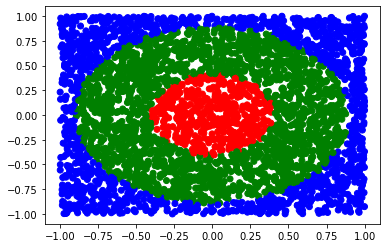

In [12]:
data, settings = generate_annulus_data(4000)

colors = ['red','green','blue']
plt.scatter(data[0][:, 0], data[0][:, 1], c=data[1], cmap=matplotlib.colors.ListedColormap(colors))

As in the paper, we use only 200 of the 4000 points for training, while the majority of points is used for validation.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data[0], data[1], test_size=0.95)

## Training and results

Let's train the model and plot the prediction of the test set using a model with three layers:

In [7]:
results = train(x_train, y_train, 3)

In [8]:
params = results.x
ys = predict(params, x_test, 3)

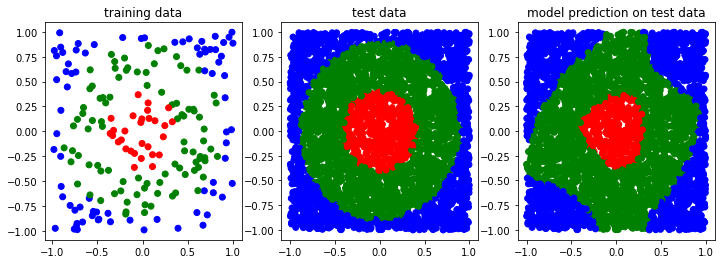

In [9]:
colors = ['red','green','blue']
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("training data")
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(132)
plt.title("test data")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(133)
plt.title("model prediction on test data with 3 layers")
plt.scatter(x_test[:,0], x_test[:, 1], c=ys, cmap=matplotlib.colors.ListedColormap(colors))

We see that the model captures the structure of the data in principle. There is some inaccuracy between class *blue* and *green*. This might be explained by the sparsity of the training data.

As a next step, we sweep over the number of layers to see the impact of the model depth and find the optimal number of rotations.

In [10]:
# sweep over layer number
nlayers = np.arange(1, 6, dtype=int)
accuracy = np.zeros(len(nlayers))

for i, n in enumerate(nlayers):
  results = train(x_train, y_train, n)
  params = results.x
  ys = predict(params, x_test, n)
  accuracy[i] = (ys == y_test).sum() / len(y_test)
  print(f"Number of layers: {n} - accuracy: {accuracy[i]}")

Number of layers: 1 - accuracy: 0.48
Number of layers: 2 - accuracy: 0.6960526315789474
Number of layers: 3 - accuracy: 0.8773684210526316
Number of layers: 4 - accuracy: 0.9031578947368422
Number of layers: 5 - accuracy: 0.9086842105263158


Text(0, 0.5, 'accuracy')

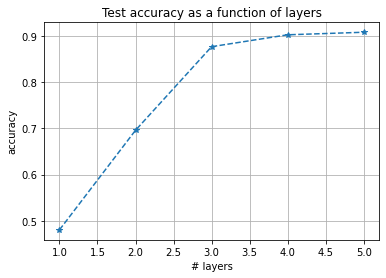

In [11]:
plt.plot(nlayers, accuracy, "*--")
plt.grid()
plt.title("Test accuracy as a function of layers")
plt.xlabel("# layers")
plt.ylabel("accuracy")

Clearly, the model accuracy increases rapidly with an increasing number of layers. While the performance seems to approach a plateau around 4 layers, minor improvements might be reachable with deeper models.

For a visual comparison, we plot the classified test data for the best performing model.

In [13]:
ys = predict(params, x_test, n)

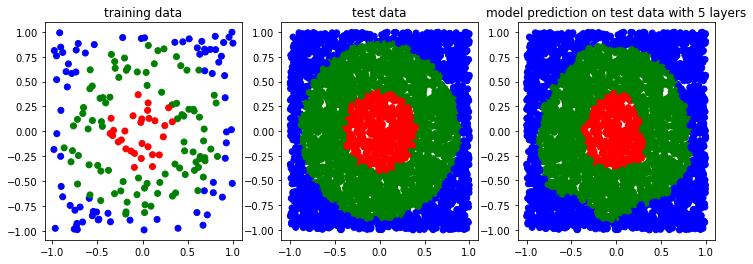

In [15]:
colors = ['red','green','blue']
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("training data")
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(132)
plt.title("test data")
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=matplotlib.colors.ListedColormap(colors))

plt.subplot(133)
plt.title(f"model prediction on test data with {n} layers")
plt.scatter(x_test[:,0], x_test[:, 1], c=ys, cmap=matplotlib.colors.ListedColormap(colors))

Comparing the model predictions with three and five layers, we can see quite some improvement going to the deeper model